# COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization 

## Implementation

#### Authors:
1. Yinghua Zhou | SID: 530833345 | UniKey: yzho0423
2.
3.

### 1. Load Dataset

#### Load ORL Dataset and Extended YaleB Dataset.
- ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 46x56 pixels.

- Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import mean_squared_error
import warnings

warnings.simplefilter('ignore')

In [2]:
def load_data(root, reduce):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    Acknowledgement: This function is completely from the assignment 1 instruction ipynb file of COMP4328/5328
    Advanced Machine Learning course at University of Sydney. For the purpose of loading data only.
    """
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')  # grey image.

            # reduce computation complexity.
            img = img.resize([s // reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1, 1))

            # collect data and label.
            images.append(img / 255.0)  # normalize to [0, 1], easier to work with for many algorithms.
            labels.append(i)

    # concat all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [3]:
reduce_ = 4

# Load Extended YaleB dataset.
X_hat, Y_hat = load_data(root='../data/CroppedYaleB', reduce=reduce_)
print('Extended YaleB dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))
img_size = [i // reduce_ for i in (168, 192)]

Extended YaleB dataset: X_hat.shape = (2016, 2414), Y_hat.shape = (2414,)


In [4]:
reduce_ = 3

# Load ORL dataset.
X_hat, Y_hat = load_data(root='../data/ORL', reduce=reduce_)
print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))
img_size = [i // reduce_ for i in (92, 112)]

ORL dataset: X_hat.shape = (1110, 400), Y_hat.shape = (400,)


###  2. Noise Adder Functions

In [5]:
def add_gaussian_noise(img, mean=0, sd=0.05):
    """
     In a sense, the standard deviation in gaussian noise can be thought of
     as the degree of noise, and mean as the standard noise.

    :param img: Original image.
    :param mean: Mean of the gaussian noise.
    :param sd: Standard deviation of the gaussian noise.
    :return: Noisy image.
    """
    noise = np.random.normal(mean, sd, img.shape)

    return np.clip(img + noise, 0, 1)

In [6]:
def add_salt_pepper_noise(img, noise_prob=0.3, salt_prob=0.5):
    """
    Add salt and pepper noise to the image.
    :param img: Original image.
    :param noise_prob: Probability of the noise.
    :param salt_prob: Probability of the salt noise. Pepper noise is 1 - salt_prob.
    :return: Noisy image.
    """
    # Create a mask for the pixels that will have noise
    noise_mask = np.random.rand(*img.shape) < noise_prob

    # Create a mask for salt (within the previously chosen noise pixels)
    salt_mask = np.random.rand(*img.shape) < salt_prob

    # Copy the original image
    noisy_img = img.copy()

    # Apply salt and pepper noise using the masks
    noisy_img[noise_mask & salt_mask] = 1  # apply salt noise
    noisy_img[noise_mask & ~salt_mask] = 0  # apply pepper noise

    return noisy_img

In [7]:
def add_block_occlusion_noise(img, img_size, width=0.3, height=0.3):
    assert width < 1, "width needs to be less than 1"
    assert height < 1, "height needs to be less than 1"
    
    img_copy = img.copy()
    
    num_samples = img_copy.shape[1]
    
    img_copy = img_copy.T.reshape(num_samples, img_size[1], img_size[0])
    
    block_height = int(img_size[1] * height)
    block_width = int(img_size[0] * width)
    
    for i in range(num_samples):
        start_x = np.random.randint(0, img_size[0] - block_width)
        start_y = np.random.randint(0, img_size[1] - block_height)
        
        img_copy[i, start_y:start_y+block_height, start_x:start_x+block_width] = 1  # Set to white
    
    return img_copy.reshape(num_samples, img_size[0] * img_size[1]).T

In [8]:
X_noise = add_salt_pepper_noise(X_hat, noise_prob=0.5)#add_block_occlusion_noise(X_hat, img_size, width=0.5, height=0.5)

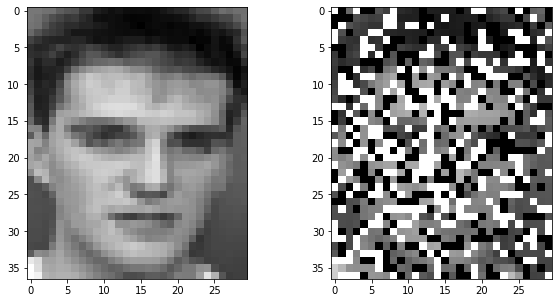

In [9]:
noise_demo_img_index = 230

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(X_hat[:,noise_demo_img_index].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(122)
plt.imshow(X_noise[:,noise_demo_img_index].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

In [10]:
# # Global centering
# X_noise = X_noise.T - X_noise.T.mean(axis=0)

# # local centering
# X_noise -= X_noise.mean(axis=1).reshape(X_hat.shape[1], -1)
# X_noise = X_noise.T

In [11]:
# plt.figure(figsize=(10,5))
# plt.subplot(111)
# plt.imshow(X_noise[:,noise_demo_img_index].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

### 3. Evaluation Metrics

In [12]:
def assign_cluster_label(X, Y):
    """
    Assign cluster labels to the transformed data matrix via KMeans clustering.
    :param X: Transformed data matrix.
    :param Y: Original labels.
    :return: Y_pred

    Acknowledgement: This function is completely from the assignment 1 instruction ipynb file of COMP4328/5328
    Advanced Machine Learning course at University of Sydney.
    """
    kmeans = KMeans(n_clusters=len(set(Y)), random_state=0).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        """for each centroid, label its instances by majority"""
        ind = kmeans.labels_ == i  # get the index of instances which labeled as i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0]  # assign label.
    return Y_pred


def calc_rmse(V_clean, W, H):
    """
    Calculate the Rooted Mean Squared Error (RMSE) between the original data matrix and the reconstructed data matrix.
    :return: RMSE
    """
    return np.sqrt(mean_squared_error(V_clean, W @ H))


def calc_aa(Y, Y_pred):
    """Calculate the Average Accuracy (AA) between the original labels and the predicted labels."""
    return accuracy_score(Y, Y_pred)


def calc_nmi(Y, Y_pred):
    """Calculate the Normalized Mutual Information (NMI) between the original labels and the predicted labels."""
    return normalized_mutual_info_score(Y, Y_pred)


def evaluate(V_clean, W, H, Y):
    """
    Evaluate the performance of the model by calculating the following metrics:
    1. Rooted Mean Squared Error (RMSE)
    2. Average Accuracy
    3. Normalized Mutual Information (NMI)

    :return: RMSE, AA, NMI
    """
    assert V_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
    assert W is not None, "Please provide the dictionary matrix."
    assert H is not None, "Please provide the transformed data matrix."
    assert Y is not None, "Please provide the original labels from the dataset."

    rmse = calc_rmse(V_clean, W, H)

    Y_pred = assign_cluster_label(H.T, Y)
    Y_pred_ori = assign_cluster_label(V_clean.T, Y)
    
    aa = calc_aa(Y, Y_pred)
    oaa = calc_aa(Y, Y_pred_ori)
    naa = aa / oaa
    
    nmi = calc_nmi(Y, Y_pred)
    onmi = calc_nmi(Y, Y_pred_ori)
    nnmi = nmi / onmi

    return rmse, naa, nnmi


def plot_metrics(rmse, aa, nmi, plot_interval):
    plt.figure(figsize=(15, 5))

    # Plot for Rooted Mean Squared Error
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
    plt.plot(np.array(range(len(rmse))) * plot_interval, rmse)
    plt.xlabel('Steps')
    plt.ylabel('Rooted Mean Squared Error')
    plt.title('Rooted Mean Squared Error')

    # Plot for Average Accuracy
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
    plt.plot(np.array(range(len(aa))) * plot_interval, aa)
    plt.xlabel('Steps')
    plt.ylabel('Average Accuracy')
    plt.title('Average Accuracy')

    # Plot for Normalized Mutual Information
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
    plt.plot(np.array(range(len(nmi))) * plot_interval, nmi)
    plt.xlabel('Steps')
    plt.ylabel('Normalized Mutual Information')
    plt.title('Normalized Mutual Information')

    # Show all plots
    plt.tight_layout()
    plt.show()

### 4. NMF Algorithms

#### 4.1 L2 Norm based Standard NMF (via MUR)

In [13]:
class L2NormMURNMF:
    def __init__(self, rank, random_state=0):
        """
        Initialize the L2-Norm Multiplicative Update Rule Non-Negative Matrix Factorization model.
        Hyper-parameters are defined here.

        :param rank: Rank of the dictionary matrix. Latent dimension.
        :param random_state: Random seed.
        """
        assert rank is not None and rank > 0, "Please provide a valid integer for the rank of the dictionary matrix."

        self.np_rand = np.random.RandomState(random_state)
        self.rank = rank
        self.V_clean, self.V, self.W, self.H, self.Y = None, None, None, None, None

    def init_factors(self, V):
        """
        Initialize the dictionary matrix and transformed data matrix *randomly*.

        :param V: Original data matrix.
        :return: W, H
        """

        self.W = self.np_rand.rand(V.shape[0], self.rank)
        self.H = self.np_rand.rand(self.rank, V.shape[1])

    def reconstruct_train(self):
        """
        Reconstruct the trained data matrix from the dictionary matrix and transformed data matrix.

        :return: approximated V
        """
        return self.W @ self.H

    def fit_transform(self, V_clean, V, Y, steps=1000, e=1e-7, d=1e-6, verbose=False, plot=False, plot_interval=50):
        """
        Perform *Multiplicative Update Rule* for Non-Negative Matrix Factorization.

        :param V_clean: Original non-contaminated data matrix.
        :param V: Original data matrix. (Contains contamination)
        :param Y: Original labels.
        :param steps: Number of iterations.
        :param e: epsilon, added to the updates avoid numerical instability
        :param d: delta, threshold for rate of change at each step
        :param verbose: True to print out the convergence information
        :param plot: True to plot the convergence curve on the three nominated metrics
        :param plot_interval: Plot the convergence curve on the metrics every plot_interval step
        :return: W, H

        Acknowledgement: This function is inspired by and has components from the corresponding function
        in the week 6 tutorial ipynb file of COMP4328/5328 Advanced Machine Learning course at University of Sydney.
        """
        assert V_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
        assert V is not None, "Please provide the original data matrix from the dataset."
        assert Y is not None, "Please provide the original labels from the dataset."

        self.init_factors(V)
        self.V_clean, self.V, self.Y = V_clean, V, Y

        rmse, aa, nmi = [], [], []

        start = time()

        for s in range(steps):
            """Please note in the corresponding tutorial, H is updated first, then W."""
            Hu = self.H * (self.W.T @ self.V) / (self.W.T @ self.W @ self.H + e) + e  # Update H
            Wu = self.W * (self.V @ Hu.T) / (self.W @ Hu @ Hu.T + e) + e  # Update W

            d_W = np.sqrt(np.sum((Wu-self.W)**2, axis=(0, 1)))/self.W.size
            d_H = np.sqrt(np.sum((Hu-self.H)**2, axis=(0, 1)))/self.H.size

            if d_W < d and d_H < d:
                if verbose:
                    print('Converged at step {}.'.format(s))
                break

            self.W = Wu
            self.H = Hu

            if plot and s % plot_interval == 0:
                rmse_, aa_, nmi_ = evaluate(self.V_clean, self.W, self.H, self.Y)
                rmse.append(rmse_)
                aa.append(aa_)
                nmi.append(nmi_)

                if verbose:
                    print('Step: {}, RMSE: {:.4f}, AA: {:.4f}, NMI: {:.4f}'.format(s, rmse_, aa_, nmi_))

        if plot:
            plot_metrics(rmse, aa, nmi, plot_interval)

        if verbose:
            print('Training Time taken: {:.2f} seconds.'.format(time()-start))

        return self.W, self.H

Step: 0, RMSE: 0.1576, AA: 0.2297, NMI: 0.3617
Step: 50, RMSE: 0.1723, AA: 0.2466, NMI: 0.4063
Step: 100, RMSE: 0.1782, AA: 0.2500, NMI: 0.4005
Step: 150, RMSE: 0.1797, AA: 0.2804, NMI: 0.4081
Step: 200, RMSE: 0.1804, AA: 0.2939, NMI: 0.4322
Step: 250, RMSE: 0.1808, AA: 0.2703, NMI: 0.4365
Step: 300, RMSE: 0.1811, AA: 0.2770, NMI: 0.4377
Step: 350, RMSE: 0.1813, AA: 0.2804, NMI: 0.4388
Step: 400, RMSE: 0.1815, AA: 0.2770, NMI: 0.4232
Step: 450, RMSE: 0.1816, AA: 0.2736, NMI: 0.4401
Step: 500, RMSE: 0.1818, AA: 0.2736, NMI: 0.4197
Step: 550, RMSE: 0.1819, AA: 0.2838, NMI: 0.4416
Step: 600, RMSE: 0.1819, AA: 0.2736, NMI: 0.4273
Step: 650, RMSE: 0.1820, AA: 0.2770, NMI: 0.4335
Step: 700, RMSE: 0.1821, AA: 0.2736, NMI: 0.4282
Step: 750, RMSE: 0.1822, AA: 0.2872, NMI: 0.4435
Step: 800, RMSE: 0.1822, AA: 0.2770, NMI: 0.4272
Step: 850, RMSE: 0.1823, AA: 0.3007, NMI: 0.4451
Step: 900, RMSE: 0.1823, AA: 0.2770, NMI: 0.4141
Step: 950, RMSE: 0.1823, AA: 0.2736, NMI: 0.4176


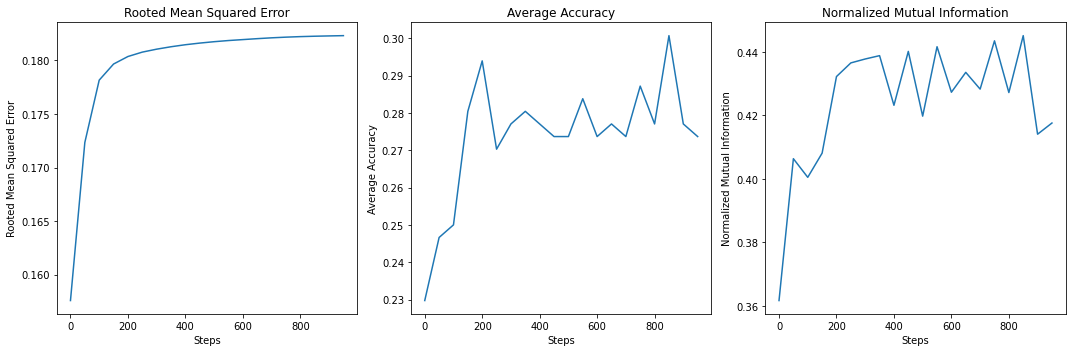

Training Time taken: 6.95 seconds.


In [14]:
model1 = L2NormMURNMF(30)

_, _ = model1.fit_transform(X_hat, X_noise, Y_hat, verbose=True, plot=True)

In [15]:
evaluate(X_hat, model1.W, model1.H, Y_hat)

(0.18234240032256252, 0.2736486486486487, 0.4012462626365621)

In [16]:
X_rec = model1.reconstruct_train()

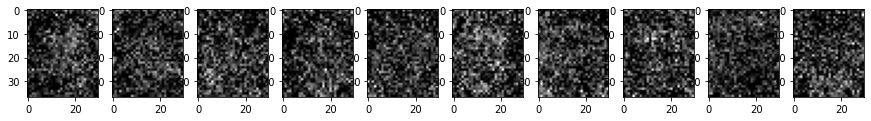

In [17]:
# Print out dictionary components

plt.figure(figsize=(15,5))

for i in range(1):
    for j in range(10):
        plt.subplot(1, 10, i * 10 + j + 1)
        plt.imshow(model1.W[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

image index:  203


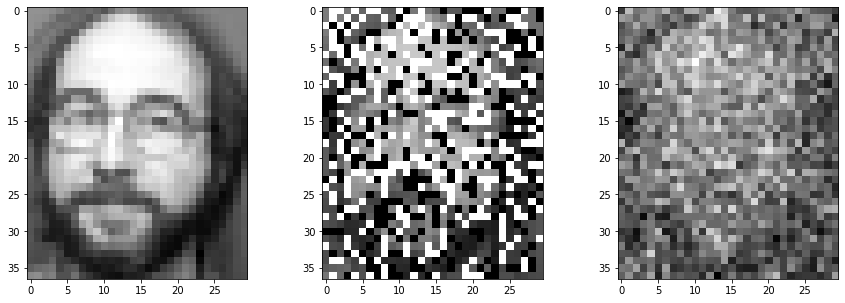

In [18]:
s = np.random.randint(0, X_hat.shape[1])
print("image index: ", s)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(X_hat[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(132)
plt.imshow(X_noise[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(133)
plt.imshow(X_rec[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

##### Observation
From here, we can actually see Standard NMF if applied to noisy images will have the noise leaked into the dictionary, and hence the reconstructed data. The reconstructed data is heavily influenced by the noise injected into the original data, and the influence is much obvious for salt and pepper noise, tho gaussian noise is still present in the dictionary if applied.

#### 4.2 Robust Nonnegative Matrix Factorization via L1 Norm Regularization (L1 Norm based Robust NMF)

In [19]:
class L1NormRobustNMF:
    def __init__(self, rank, lambda_=0.04, random_state=0):
        """
        Initialization of the Robust Non-negative Matrix Factorization via L1 Norm Regularization NMF model.
        Hyper-parameters are defined here.

        :param rank: Rank of the dictionary matrix. Latent dimension.
        :param lambda_: Regularization parameter.
        :param random_state: Random seed.
        """
        assert rank is not None and rank > 0, "Please provide a valid integer for the rank of the dictionary matrix."
        assert lambda_ is not None and lambda_ > 0, "Please provide a valid numeric for the regularization parameter."

        self.np_rand = np.random.RandomState(random_state)
        self.k = rank
        self.lambda_ = lambda_

        self.X_clean, self.X, self.W, self.H, self.E, self.Y = None, None, None, None, None, None
        self.m, self.n = None, None  # Number of features/pixels, and number of samples (rows and cols)

    def init_factors(self, X):
        """
        Initialize the dictionary matrix and transformed data matrix and the noise matrix *randomly*.

        :param X: Original data matrix.
        :return: W, H, E
        """

        self.m, self.n = X.shape

        self.W = np.abs(np.random.normal(loc=0.0, scale=1, size=(self.m, self.k)))
        self.H = np.abs(np.random.normal(loc=0.0, scale=1, size=(self.k, self.n)))
        self.E = np.abs(np.random.normal(loc=0.0, scale=1, size=(self.m, self.n)))

        return self.W, self.H, self.E

    def reconstruct_train(self):
        """
        Reconstruct the clean data matrix from the dictionary matrix and transformed data matrix.

        :return: approximated clean data matrix.
        """
        return self.W @ self.H

    def fit_transform(self, X_clean, X, Y, steps=1000, d=1e-6, verbose=False, plot=False, plot_interval=50):
        """
        Perform the model learning via the specific MURs stated in the paper.

        :param X_clean: Original non-contaminated data matrix.
        :param X: Original contaminated data matrix.
        :param Y: Original labels.
        :param steps: Number of iterations.
        :param d: delta, param change threshold for stopping.
        :param verbose: True to print out the convergence information.
        :param plot: True to plot the convergence curve on the three nominated metrics.
        :param plot_interval: Plot the convergence curve on the metrics every plot_interval step.
        :return: U, V, E
        """
        assert X_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
        assert X is not None, "Please provide the original data matrix from the dataset."
        assert Y is not None, "Please provide the original labels from the dataset."

        self.init_factors(X)
        self.X_clean, self.X, self.Y = X_clean, X, Y

        rmse, aa, nmi = [], [], []

        start = time()

        for s in range(steps):
            # Extract/Synthesize update components specified in the paper
            X_hat = self.X - self.E
            Wu = self.W * ((X_hat @ self.H.T) / (self.W @ self.H @ self.H.T))

            X_tilde = np.vstack((self.X, np.zeros((1, self.n))))

            I = np.eye(self.m)

            e_m = np.full((1, self.m), np.sqrt(self.lambda_) * np.exp(1))
            U_tilde = np.vstack((np.hstack((Wu, I, -I)), np.hstack((np.zeros((1, self.k)), e_m, e_m))))
            S = np.abs(U_tilde.T @ U_tilde)

            Ep = (np.abs(self.E) + self.E) / 2
            En = (np.abs(self.E) - self.E) / 2

            V_tilde = np.vstack((self.H, np.vstack((Ep, En))))

            V_tilde = np.maximum(0, V_tilde - ((V_tilde * (U_tilde.T @ U_tilde @ V_tilde)) / (S @ V_tilde))
                                 + ((V_tilde * (U_tilde.T @ X_tilde)) / (S @ V_tilde)))

            Hu = V_tilde[:self.k, :]
            Epu = V_tilde[self.k:self.k + self.m, :]
            Enu = V_tilde[self.k + self.m:, :]

            Eu = Epu - Enu  # Mathematically, this operation gives you back E
            
            d_W = np.sqrt(np.sum((Wu  - self.W) ** 2, axis=(0, 1))) / self.W.size
            d_H = np.sqrt(np.sum((Hu - self.H) ** 2, axis=(0, 1))) / self.H.size
            d_E = np.sqrt(np.sum((Eu - self.E) ** 2, axis=(0, 1))) / self.E.size

            if d_W < d and d_H < d and d_E < d:
                if verbose:
                    print('Converged at step {}.'.format(s))
                break

            self.W = Wu
            self.H = Hu
            self.E = Eu

            if plot and s % plot_interval == 0:
                rmse_, aa_, nmi_ = evaluate(self.X_clean, self.W, self.H, self.Y)
                rmse.append(rmse_)
                aa.append(aa_)
                nmi.append(nmi_)

                if verbose:
                    print('Step: {}, RMSE: {:.4f}, AA: {:.4f}, NMI: {:.4f}'.format(s, rmse_, aa_, nmi_))

        if plot:
            plot_metrics(rmse, aa, nmi, plot_interval)

        if verbose:
            print('Training Time taken: {:.2f} seconds.'.format(time() - start))

        return self.W, self.H, self.E


Step: 0, RMSE: 0.7790, AA: 0.2196, NMI: 0.3503
Step: 50, RMSE: 0.1702, AA: 0.2399, NMI: 0.3907
Step: 100, RMSE: 0.1764, AA: 0.2736, NMI: 0.4408
Step: 150, RMSE: 0.1784, AA: 0.2534, NMI: 0.4201
Step: 200, RMSE: 0.1794, AA: 0.2601, NMI: 0.4151
Step: 250, RMSE: 0.1800, AA: 0.2500, NMI: 0.4007
Step: 300, RMSE: 0.1804, AA: 0.2534, NMI: 0.3945
Step: 350, RMSE: 0.1806, AA: 0.2804, NMI: 0.4396
Step: 400, RMSE: 0.1809, AA: 0.2534, NMI: 0.3904
Step: 450, RMSE: 0.1810, AA: 0.2669, NMI: 0.4240
Step: 500, RMSE: 0.1811, AA: 0.2601, NMI: 0.3990
Step: 550, RMSE: 0.1812, AA: 0.2534, NMI: 0.4025
Step: 600, RMSE: 0.1813, AA: 0.2736, NMI: 0.4105
Step: 650, RMSE: 0.1814, AA: 0.2736, NMI: 0.3958
Step: 700, RMSE: 0.1814, AA: 0.2736, NMI: 0.4194
Step: 750, RMSE: 0.1815, AA: 0.2872, NMI: 0.4386
Step: 800, RMSE: 0.1815, AA: 0.2973, NMI: 0.4376
Step: 850, RMSE: 0.1816, AA: 0.2804, NMI: 0.4371
Step: 900, RMSE: 0.1816, AA: 0.2703, NMI: 0.4224
Step: 950, RMSE: 0.1817, AA: 0.2770, NMI: 0.4182


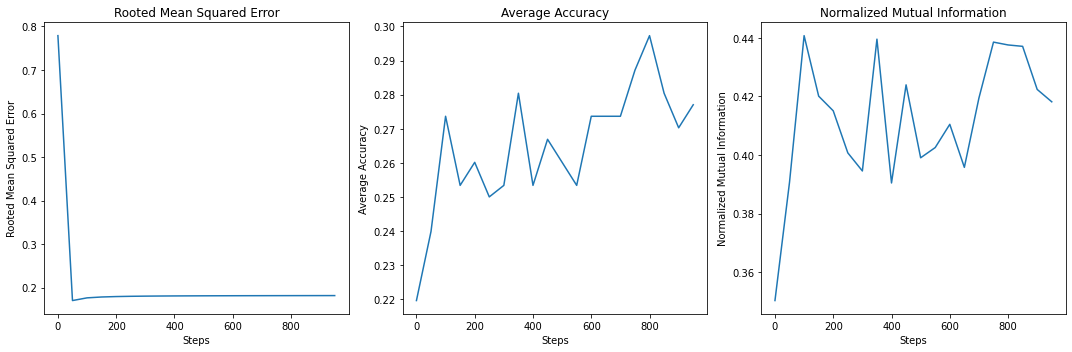

Training Time taken: 166.89 seconds.


In [20]:
model2 = L1NormRobustNMF(30)

_, _, _ = model2.fit_transform(X_hat, X_noise, Y_hat, verbose=True, plot=True)

In [21]:
evaluate(X_hat, model2.W, model2.H, Y_hat)

(0.18168536279649647, 0.27702702702702703, 0.4327877444469051)

In [22]:
X_rec2 = model2.reconstruct_train()

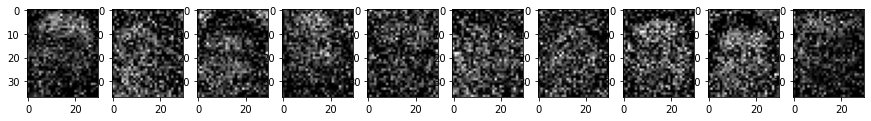

In [23]:
# Print out dictionary components

plt.figure(figsize=(15,5))

for i in range(1):
    for j in range(10):
        plt.subplot(1, 10, i * 10 + j + 1)
        plt.imshow(model2.W[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

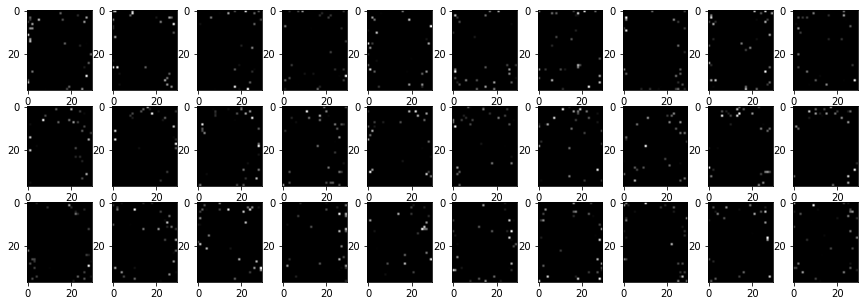

In [24]:
# Print out the learned noises E

plt.figure(figsize=(15,5))

for i in range(3):
    for j in range(10):
        plt.subplot(3, 10, i * 10 + j + 1)
        plt.imshow(model2.E[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

image index:  0


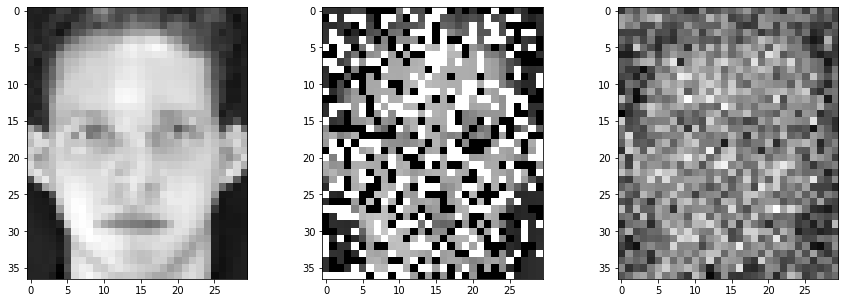

In [25]:
s = 0#np.random.randint(0, X_hat.shape[1])
print("image index: ", s)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(X_hat[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(132)
plt.imshow(X_noise[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(133)
plt.imshow(X_rec2[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

#### 4.3 Robust nonnegative matrix factorization using L21-norm (L21 Norm based Robust NMF)

In [26]:
class L21RobustNMF:
    def __init__(self, rank, random_state=0):
        """
        Initialization of the Robust Non-negative Matrix Factorization via L1 Norm Regularization NMF model.
        Hyper-parameters are defined here.

        :param rank: Rank of the dictionary matrix. Latent dimension.
        :param random_state: Random seed.
        """
        assert rank is not None and rank > 0, "Please provide a valid integer for the rank of the dictionary matrix."

        self.np_rand = np.random.RandomState(random_state)
        self.rank = rank

        self.X_clean, self.X, self.W, self.H, self.Y = None, None, None, None, None

    def init_factors(self, X):
        """
        Initialize the dictionary matrix and transformed data matrix *randomly*.

        :param X: Original data matrix. (Contaminated)
        :return: W, H
        """

        self.W = np.abs(np.random.normal(loc=0.0, scale=1, size=(X.shape[0], self.rank)))
        self.H = np.abs(np.random.normal(loc=0.0, scale=1, size=(self.rank, X.shape[1])))

        #         self.W = self.np_rand.rand(X.shape[0], self.rank)
        #         self.H = self.np_rand.rand(self.rank, X.shape[1])

        return self.W, self.H

    def reconstruct_train(self):
        """
        Reconstruct the clean data matrix from the dictionary matrix and transformed data matrix.

        :return: approximated clean data matrix.
        """
        return self.W @ self.H

    def fit_transform(self, X_clean, X, Y, steps=1000, e=1e-7, d=1e-6, verbose=False, plot=False, plot_interval=50):
        """
        Perform the model learning via the specific MURs stated in the paper.

        :param X_clean: Original non-contaminated data matrix.
        :param X: Original contaminated data matrix.
        :param Y: Original labels.
        :param steps: Number of iterations.
        :param e: epsilon, added to the updates avoid numerical instability.
        :param d: delta, threshold for rate of change at each step.
        :param verbose: True to print out the convergence information.
        :param plot: True to plot the convergence curve on the three nominated metrics.
        :param plot_interval: Plot the convergence curve on the metrics every plot_interval step.
        :return: W, H
        """
        assert X_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
        assert X is not None, "Please provide the original data matrix from the dataset."
        assert Y is not None, "Please provide the original labels from the dataset."

        self.init_factors(X)
        self.X_clean, self.X, self.Y = X_clean, X, Y

        rmse, aa, nmi = [], [], []

        start = time()

        for s in range(steps):
            D = np.diag(1 / (np.sqrt(np.sum((self.X - self.W @ self.H) ** 2, axis=0)) + e))

            Wu = self.W * ((self.X @ D @ self.H.T) / (self.W @ self.H @ D @ self.H.T + e))
            Hu = self.H * ((Wu .T @ self.X @ D) / (Wu .T @ Wu  @ self.H @ D + e))

            d_W = np.sqrt(np.sum((Wu  - self.W) ** 2, axis=(0, 1))) / self.W.size
            d_H = np.sqrt(np.sum((Hu - self.H) ** 2, axis=(0, 1))) / self.H.size

            if d_W < d and d_H < d:
                if verbose:
                    print('Converged at step {}.'.format(s))
                break

            self.W = Wu
            self.H = Hu

            if plot and s % plot_interval == 0:
                rmse_, aa_, nmi_ = evaluate(self.X_clean, self.W, self.H, self.Y)
                rmse.append(rmse_)
                aa.append(aa_)
                nmi.append(nmi_)

                if verbose:
                    print('Step: {}, RMSE: {:.4f}, AA: {:.4f}, NMI: {:.4f}'.format(s, rmse_, aa_, nmi_))

        if plot:
            plot_metrics(rmse, aa, nmi, plot_interval)

        if verbose:
            print('Training Time taken: {:.2f} seconds.'.format(time() - start))

        return self.W, self.H

Step: 0, RMSE: 0.1614, AA: 0.2399, NMI: 0.3848
Step: 50, RMSE: 0.1730, AA: 0.2736, NMI: 0.4181
Step: 100, RMSE: 0.1776, AA: 0.2669, NMI: 0.4191
Step: 150, RMSE: 0.1790, AA: 0.2973, NMI: 0.4444
Step: 200, RMSE: 0.1797, AA: 0.2669, NMI: 0.4147
Step: 250, RMSE: 0.1800, AA: 0.3041, NMI: 0.4622
Step: 300, RMSE: 0.1803, AA: 0.2770, NMI: 0.4327
Step: 350, RMSE: 0.1805, AA: 0.2736, NMI: 0.4340
Step: 400, RMSE: 0.1806, AA: 0.2905, NMI: 0.4695
Step: 450, RMSE: 0.1807, AA: 0.2669, NMI: 0.4058
Step: 500, RMSE: 0.1808, AA: 0.2838, NMI: 0.4315
Step: 550, RMSE: 0.1809, AA: 0.2804, NMI: 0.4420
Step: 600, RMSE: 0.1810, AA: 0.3041, NMI: 0.4250
Step: 650, RMSE: 0.1811, AA: 0.2804, NMI: 0.4177
Step: 700, RMSE: 0.1812, AA: 0.2770, NMI: 0.4415
Step: 750, RMSE: 0.1813, AA: 0.2838, NMI: 0.4417
Step: 800, RMSE: 0.1813, AA: 0.2635, NMI: 0.4244
Step: 850, RMSE: 0.1814, AA: 0.2973, NMI: 0.4482
Step: 900, RMSE: 0.1814, AA: 0.3074, NMI: 0.4583
Step: 950, RMSE: 0.1815, AA: 0.2703, NMI: 0.4213


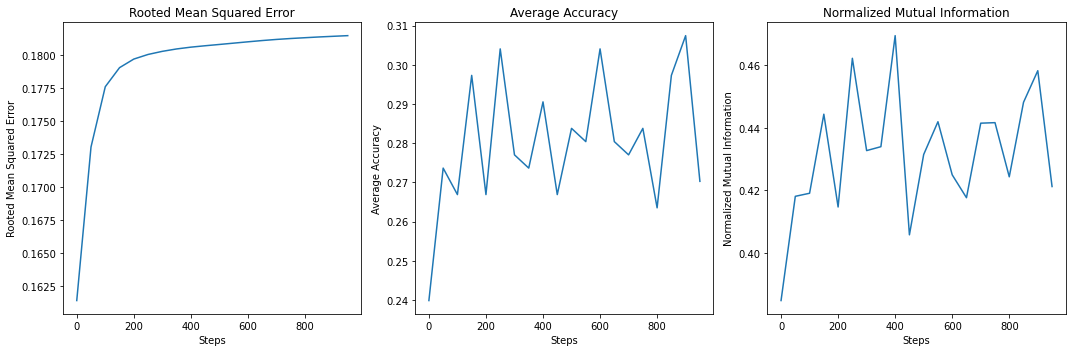

Training Time taken: 13.00 seconds.


In [27]:
model3 = L21RobustNMF(30)

_, _ = model3.fit_transform(X_hat, X_noise, Y_hat, verbose=True, plot=True)

In [28]:
evaluate(X_hat, model3.W, model3.H, Y_hat)

(0.1815204828608197, 0.2972972972972973, 0.4293532869498997)

In [29]:
X_rec3 = model3.reconstruct_train()

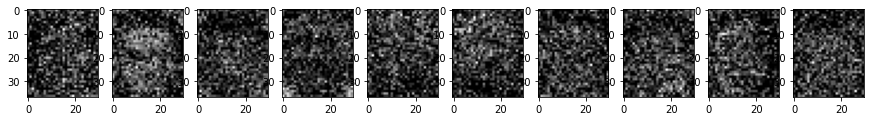

In [30]:
# Print out dictionary components

plt.figure(figsize=(15, 5))

for i in range(1):
    for j in range(10):
        plt.subplot(1, 10, i * 10 + j + 1)
        plt.imshow(model3.W[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

image index:  179


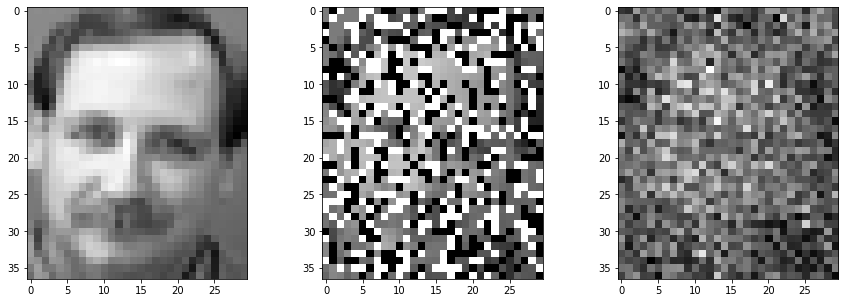

In [31]:
s = np.random.randint(0, X_hat.shape[1])
print("image index: ", s)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(X_hat[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(132)
plt.imshow(X_noise[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(133)
plt.imshow(X_rec3[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

### 5. Experiements

In [ ]:
n_experiments = 5
train_size_ratio = 0.9
max_steps = 1000
n_components = 10

def run_experiments(X_clean, Y, train_size_ratio, k, steps, n_experiments, noise_strength_traversal=False):
    if noise_strength_traversal:
        gaussian_sd_str = [0.02, 0.05, 0.1, 0.15, 0.2]
        salt_pepper_p_str = [0.1, 0.2, 0.3, 0.4, 0.5]
        block_occ_size_str = [0.1, 0.2, 0.3, 0.4, 0.5]
    else:
        gaussian_sd_str = [0.05]
        salt_pepper_p_str = [0.3]
        block_occ_size_str = [0.3]
    
    means = []  # [[means for the first noise], [...], [...]] - Will result in a 3 x 5 x 3 x 3 tensor
    stds = []  # [[standard deviations for the first noise], [...], [...]]
    
    for n in ["gaussian", "salt_pepper", "block_occ"]:
        n_means = []  # means under different noise
        n_stds = []  # sd under different noise
        
        if n == "gaussian":
            strengths = gaussian_sd_str
        elif n == "salt_pepper":
            strengths = salt_pepper_p_str         
        else:
            strengths = block_occ_size_str         
        
        for s in strengths:
            ns_means = [] # mean of the three NMF algorithms across number of experiements - [(RMSE, AA, NMI), (...), (...)]
            ns_stds = [] # standard deviations of the three NMF algorithms across number of experiements under diff strengths
            
            for m in ["StandardL2", "L1Robust", "L21Robust"]:
                if m == "StandardL2":
                    model = L2NormMURNMF(k)
                elif m == "L1Robust":
                    model = L1NormRobustNMF(k)
                else:
                    model = L21RobustNMF(k)

                m_rmse = []
                m_aa = []
                m_nmi = []

                for i in range(n_experiments):
                    n_samples = int(X_clean.shape[1] * train_size_ratio)
                    sample_idx = np.random.choice(X_hat.shape[1], n_samples, replace=False) # Randomly pick samples
                    X_clean_sampled = X_clean[:, sample_idx] # Sampled matrix
                    Y_sampled = Y[sample_idx]

                    if n == "gaussian":
                        X_noise = add_gaussian_noise(X_clean_sampled, sd=s)
                    elif n == "salt_pepper":
                        X_noise = add_salt_pepper_noise(X_clean_sampled, noise_prob=s)
                    else:
                        X_noise = add_block_occlusion_noise(X_clean_sampled, img_size, width=s, height=s)

                    model.fit_transform(X_clean_sampled, X_noise, Y_sampled, steps=steps)
                    rmse, aa, nmi = evaluate(X_clean_sampled, model.W, model.H, Y_sampled)

                    m_rmse.append(rmse)
                    m_aa.append(aa)
                    m_nmi.append(nmi)

                ns_means.append((np.mean(m_rmse), np.mean(m_aa), np.mean(m_nmi)))
                ns_stds.append((np.std(m_rmse), np.std(m_aa), np.std(m_nmi)))
            
            n_means.append(ns_means)
            n_stds.append(ns_stds)
        
        means.append(n_means)
        stds.append(n_stds)
    
    return means, stds

run_experiments(X_hat, Y_hat, train_size_ratio, n_components, max_steps, n_experiments)